##### Import the required libraries ##

In [62]:
import nltk
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sqlalchemy import create_engine

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

##### Function for creating tokens for text, the docstring in the function shows additional information #####

In [64]:
def tokenize(text):
    '''
    Create tokens and then lemmatize the tokens. Useful for including in CountVectorizer
    Parameters:
        text (str): Input text to be tokenized
    '''
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for tok in tokens:
        clean_token = lemmatizer.lemmatize(tok).lower().strip()
        lemmatized_tokens.append(clean_token)
    return lemmatized_tokens

##### evaluate_model: Function to compute the performance of the prediction model - accuracy, precision and recall

In [65]:
def evaluate_model(trained_model, X_test, y_test, y_pred, column_labels, category_subset):
    '''
    Calculate accuracy, precision, recall and f1 score for the input model
    Parameters:
        trained_model: Model to be used for prediction on the test dataset
        X_test: Input for the prediction
        y_test: Ground truth or the correct prediction
        y_pred: Predicted results
        column_labels: Labels for the predicted variables
    Returns:
        trained_model_accuracy: Overall accuracy of the trained model
        accuracy_df: Dataframe containing the performance metrics on the test set
    '''
    test_result_df = pd.DataFrame(y_test, columns = column_labels)
    pred_result_df = pd.DataFrame(y_pred, columns = column_labels)
    #column = 'related'
    #accuracy = accuracy_score(test_result_df['related'], pred_result_df['related'])
    trained_model_accuracy = trained_model.score(X_test, y_test)
    accuracy_df = pd.DataFrame(data = [], columns = ['Category', 'Accuracy','Precision', 'Recall', 'F1', 'Support', 'Prominent_Category'])
    i = 0
    for column_name in column_labels:
        accuracy_score_column = round(accuracy_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        precision_score_column = round(precision_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        recall_score_column = round(recall_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        f1_score_column = round(f1_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        #print(column_name, '----', accuracy_score_column)
        if column_name in category_subset:
            balanced = True
        else:
            balanced = False
        accuracy_df.loc[i] = [column_name, accuracy_score_column, precision_score_column, recall_score_column, f1_score_column, 0, balanced]
        i += 1
    return accuracy_df, trained_model_accuracy, test_result_df, pred_result_df

##### Read the message/category dataset from the Sqlite database #####
##### Check for data imbalance #####
##### Set output features to the right format #####
##### Split the dataset into training and test set #####

In [66]:
db_engine = create_engine('sqlite:////home/prasannaiyer/Projects/NLP_Project/Data/DisasterResponse.db')
msg_df = pd.read_sql_table('Message_Category', db_engine)

##### Compute the proportion of each category in the overall dataset #####
##### This will show the categories that have low representation (less than 8%) in the dataset #####

In [67]:
msg_df_cat_proportion = pd.DataFrame((((msg_df[msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]].\
    sum())/(msg_df[msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]].\
    count())).sort_values(ascending = False)*100))

In [68]:
msg_df_cat_proportion.columns = ['Proportion']

In [69]:
prominent_categories = msg_df_cat_proportion.loc[msg_df_cat_proportion['Proportion']>8]

In [70]:
category_count_df = pd.DataFrame(msg_df[msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]].sum().\
    sort_values(ascending = False).reset_index())
category_count_df.columns = ['Category', 'Count']

#### Change the format of the output features to Int ####

In [71]:
columnn_labels = msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]

In [72]:
for column_name in msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]:
    msg_df[column_name] = msg_df[column_name].astype('int')

##### Split the dataset into training and test set #####

In [73]:
X = msg_df['message'].values
y = msg_df.loc[:, ~msg_df.columns.isin(['id', 'genre', 'message', 'original'])].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

##### Load the 2 trained models from the pickle files #####
##### Predict the output for the test set #####

In [74]:
pipeline_trained_model = pickle.load(open('/data2/home/prasannaiyer/Projects/NLP_Project/Code/pipeline_model.sav', 'rb'))
#pred_pipeline = pipeline_trained_model.predict(X_test)

In [76]:
#model_filename = open('/data2/home/prasannaiyer/Projects/NLP_Project/Code/cv_model.sav', 'rb')
cv_trained_model = pickle.load(open('/data2/home/prasannaiyer/Projects/NLP_Project/Code/cv_model.sav', 'rb'))
pred_cv = cv_trained_model.predict(X_test)

##### Evaluate the model performance -- accuracy, precision & recall #####

In [86]:
cv_model_accuracy_df, cv_model_overall_acc, cv_test_result_df, cv_pred_result_df = \
    evaluate_model(cv_trained_model, X_test, y_test, pred_cv, columnn_labels, prominent_categories.index)

/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [87]:
plain_model_accuracy_df, plain_model_overall_acc, plain_test_result_df, plain_pred_result_df = \
    evaluate_model(pipeline_trained_model, X_test, y_test, pred_cv, columnn_labels, prominent_categories.index)

/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


##### Report the performance metrics of the prediction models

In [88]:
cv_model_accuracy_df = cv_model_accuracy_df.merge(category_count_df, left_on = 'Category', right_on = 'Category')

In [85]:
prominent_categories.index

Index(['related', 'aid_related', 'weather_related', 'direct_report', 'request',
       'other_aid', 'food', 'earthquake', 'storm', 'shelter', 'floods'],
      dtype='object')

In [89]:
cv_model_accuracy_df.head(35).sort_values(by = ['Prominent_Category', 'Count'], ascending = False)

,Category,Accuracy,Precision,Recall,F1,Support,Prominent_Category,Count
0,related,0.95,0.94,0.99,0.97,0,True,20093
3,aid_related,0.94,0.96,0.90,0.93,0,True,10860
28,weather_related,0.97,0.97,0.90,0.94,0,True,7297
1,request,0.97,0.99,0.86,0.92,0,True,4474
18,other_aid,0.96,1.00,0.73,0.84,0,True,3446
11,food,0.98,0.99,0.84,0.91,0,True,2923
32,earthquake,0.99,0.98,0.92,0.95,0,True,2455
30,storm,0.98,0.96,0.86,0.91,0,True,2443
12,shelter,0.98,0.98,0.84,0.90,0,True,2314
29,floods,0.99,0.99,0.84,0.91,0,True,2155


In [111]:
cv_model_accuracy_df.groupby(by = ['Prominent_Category'])[['Accuracy', 'Precision','Recall', 'F1']].mean().style.format(precision = 2, thousands = ',')

,Accuracy,Precision,Recall,F1
Prominent_Category,,,,
False,0.99,0.96,0.72,0.82
True,0.97,0.98,0.87,0.92


In [114]:
cv_model_accuracy_prominent_cat = cv_model_accuracy_df.groupby(by = ['Prominent_Category'])[['Accuracy']].mean()['Accuracy'].loc[True]
cv_model_accuracy_other_cat = cv_model_accuracy_df.groupby(by = ['Prominent_Category'])[['Accuracy']].mean()['Accuracy'].loc[False]
cv_model_precision_prominent_cat = cv_model_accuracy_df.groupby(by = ['Prominent_Category'])[['Precision']].mean()['Precision'].loc[True]
cv_model_precision_other_cat = cv_model_accuracy_df.groupby(by = ['Prominent_Category'])[['Precision']].mean()['Precision'].loc[False]
cv_model_recall_prominent_cat = cv_model_accuracy_df.groupby(by = ['Prominent_Category'])[['Recall']].mean()['Recall'].loc[True]
cv_model_recall_other_cat = cv_model_accuracy_df.groupby(by = ['Prominent_Category'])[['Recall']].mean()['Recall'].loc[False]
cv_model_F1_prominent_cat = cv_model_accuracy_df.groupby(by = ['Prominent_Category'])[['F1']].mean()['F1'].loc[True]
cv_model_F1_other_cat = cv_model_accuracy_df.groupby(by = ['Prominent_Category'])[['F1']].mean()['F1'].loc[False]

In [115]:
print('Gridsearch Accuracy: Prominent Categories = {:.2f}% and Other Categories = {:.2f}%'.format(cv_model_accuracy_prominent_cat*100, cv_model_accuracy_other_cat*100))
print('Gridsearch Precision: Prominent Categories = {:.2f}% and Other Categories = {:.2f}%'.format(cv_model_precision_prominent_cat*100, cv_model_precision_other_cat*100))
print('Gridsearch Recall: Prominent Categories = {:.2f}% and Other Categories = {:.2f}%'.format(cv_model_recall_prominent_cat*100, cv_model_recall_other_cat*100))
print('Gridsearch F1: Prominent Categories = {:.2f}% and Other Categories = {:.2f}%'.format(cv_model_F1_prominent_cat*100, cv_model_F1_other_cat*100))

Gridsearch Accuracy: Prominent Categories = 97.09% and Other Categories = 99.36%
Gridsearch Precision: Prominent Categories = 97.64% and Other Categories = 95.64%
Gridsearch Recall: Prominent Categories = 86.55% and Other Categories = 72.36%
Gridsearch F1: Prominent Categories = 91.73% and Other Categories = 82.32%


In [91]:
print('Accuracy: Pipeline = {:.2f}% and Gridsearch = {:.2f}%'.format(plain_model_overall_acc*100, cv_model_overall_acc*100))

Accuracy: Pipeline = 30.53% and Gridsearch = 80.90%


/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

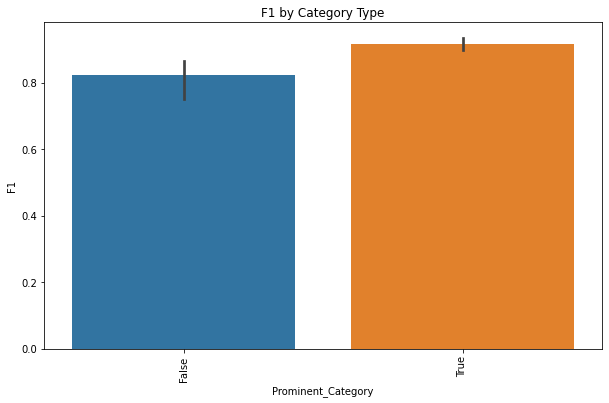

In [117]:
fig = plt.figure(figsize = (10, 6))
#ax = sns.barplot(cv_model_accuracy_df['Category'], cv_model_accuracy_df['F1'], hue = cv_model_accuracy_df['Balanced'], \
 #   order = np.append(category_subset_balanced, category_subset_unbalanced))
ax = sns.barplot(cv_model_accuracy_df['Prominent_Category'], cv_model_accuracy_df['F1'])
ax.set_title('F1 by Category Type')
plt.xticks(rotation=90)